In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators_meta
from glob import glob
from tools import get_best_model,get_predictions_per_subset
import os
from scipy.stats import norm
import scienceplots
from tqdm import tqdm
plt.style.use(["science", "grid"])

Objectives
----------
1. To see where the inception fails


In [15]:
simulationNames = ['CDM','SIDM0.1','SIDM1']
channels = ['total','stellar','xray']
data_file = 'pickles/binned_data_20.pkl'
model_name = 'inception'
train, test, params = getGenerators_meta(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, 
                                                      allDataFile=data_file,
                                                      return_test_params=True)

In [23]:

compare=[]

for checkpoint_filepath in tqdm(glob("models/%s/*" % model_name)):
    model = tf.keras.models.load_model(checkpoint_filepath)
    probs = model.predict( test[0] )
    pred = np.argmax( probs, axis=-1)
    compare.append(pred - test[1])
pkl.dump(compare, open("pickles/cnn_fails.pkl","wb"))

  0%|                                                                                 | 0/10 [00:00<?, ?it/s]

30/30 [==============================] - 2s 70ms/step


 10%|███████▎                                                                 | 1/10 [00:12<01:50, 12.25s/it]

30/30 [==============================] - 2s 67ms/step


 20%|██████████████▌                                                          | 2/10 [00:23<01:31, 11.38s/it]

30/30 [==============================] - 2s 66ms/step


 30%|█████████████████████▉                                                   | 3/10 [00:34<01:19, 11.39s/it]

30/30 [==============================] - 2s 71ms/step


 40%|█████████████████████████████▏                                           | 4/10 [00:46<01:09, 11.54s/it]

30/30 [==============================] - 2s 71ms/step


 50%|████████████████████████████████████▌                                    | 5/10 [00:57<00:57, 11.48s/it]

30/30 [==============================] - 2s 72ms/step


 60%|███████████████████████████████████████████▊                             | 6/10 [01:09<00:46, 11.55s/it]

30/30 [==============================] - 3s 73ms/step


 70%|███████████████████████████████████████████████████                      | 7/10 [01:20<00:34, 11.60s/it]

30/30 [==============================] - 2s 68ms/step


 80%|██████████████████████████████████████████████████████████▍              | 8/10 [01:32<00:23, 11.51s/it]

30/30 [==============================] - 2s 69ms/step


 90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [01:43<00:11, 11.55s/it]

30/30 [==============================] - 2s 70ms/step


100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.49s/it]


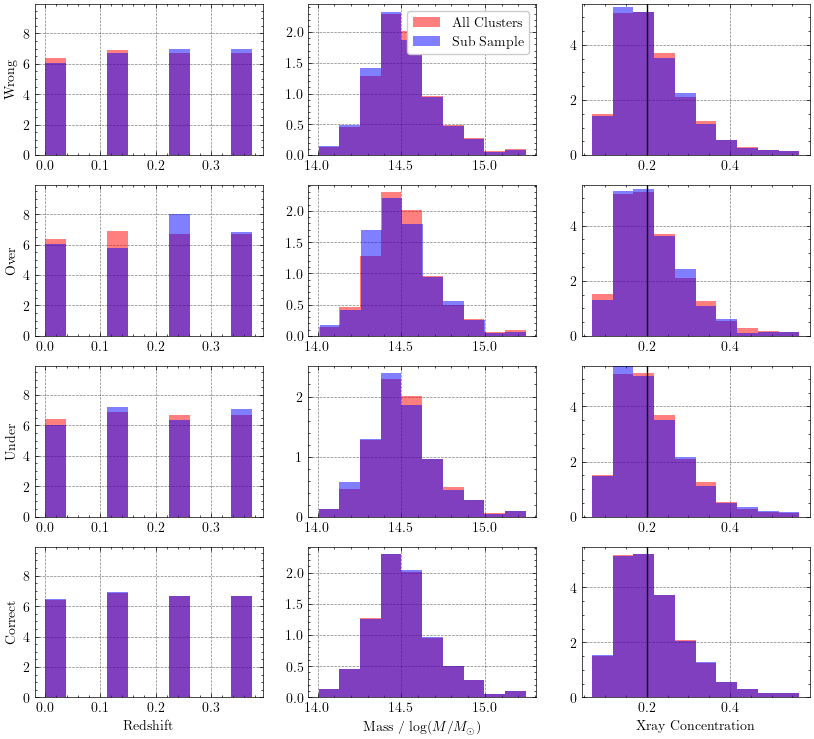

In [30]:
labels = ['redshift','mass','xrayConc']
fig, axarr = plt.subplots(4,len(labels), figsize=(10, 3*len(labels)))

compare_list = pkl.load(open("pickles/cnn_fails.pkl","rb"))

compare =  np.concatenate(compare_list)
test_params = {}
for ikey in params.keys():
    test_params[ikey] = np.repeat(params[ikey], len(compare_list))

for i, ilabel in enumerate(labels):
    for j in range(4):
        axarr[j,i].hist(test_params[ilabel], alpha=0.5, color='r', density=True, label="All Clusters")
        if i==0:
            axarr[j,i].set_ylim(0,9.9)
        if i == 2:
            ylim = axarr[j,i].get_ylim()
            axarr[j,i].plot( [0.2,0.2], [0,ylim[1]*1.1], 'k-')
            axarr[j,i].set_ylim(ylim)
    axarr[0,i].hist(test_params[ilabel][compare != 0], alpha=0.5, color='b', density=True, label='Sub Sample') 
    axarr[1,i].hist(test_params[ilabel][compare > 0], alpha=0.5, color='b', density=True, label='Over')
    axarr[2,i].hist(test_params[ilabel][compare < 0], alpha=0.5, color='b', density=True, label='Under')
    axarr[3,i].hist(test_params[ilabel][compare == 0], alpha=0.5, color='b', density=True, label='Right')

    
axarr[0,1].legend()

axarr[0,0].set_ylabel("Wrong")
axarr[1,0].set_ylabel("Over")
axarr[2,0].set_ylabel("Under")
axarr[3,0].set_ylabel("Correct")

axarr[-1,0].set_xlabel("Redshift")
axarr[-1,1].set_xlabel("Mass / log($M/M_\odot$)")
axarr[-1,2].set_xlabel("Xray Concentration")
fig.align_ylabels()
fig.align_xlabels()

plt.savefig("../plots/cnn_failure.pdf")

(array([1.58666193, 5.77707676, 4.75998578, 2.23760015, 1.50529465,
        0.81367278, 0.32546911, 0.12205092, 0.12205092, 0.04068364]),
 array([0.07478738, 0.13262245, 0.19045752, 0.24829259, 0.30612766,
        0.36396274, 0.42179781, 0.47963288, 0.53746795, 0.59530302,
        0.65313809]),
 <BarContainer object of 10 artists>)

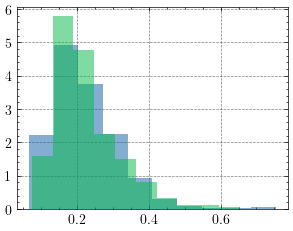

In [50]:
fig, ax = plt.subplots(1,1)
ax.hist(test_params['xrayConc'][compare != 0], density=True, alpha=0.5)
ax.hist(test_params['xrayConc'][compare == 0], density=True, alpha=0.5)

(array([0.29952575, 0.86529661, 1.71395291, 2.11332058, 1.09826109,
        0.5158499 , 0.21632415, 0.06656128, 0.16640319, 0.01664032]),
 array([14.061 , 14.2024, 14.3438, 14.4852, 14.6266, 14.768 , 14.9094,
        15.0508, 15.1922, 15.3336, 15.475 ]),
 <BarContainer object of 10 artists>)

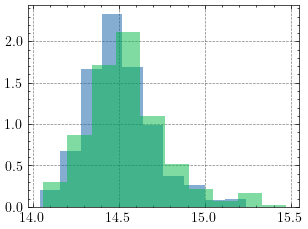

In [52]:
fig, ax = plt.subplots(1,1)
ax.hist(test_params['mass'][compare != 0], density=True, alpha=0.5)
ax.hist(test_params['mass'][compare == 0], density=True, alpha=0.5)